In [1]:
#Library
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns
import numpy as np

import sklearn
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

import statsmodels
import statsmodels.api as sm
import scipy
import scipy.stats as stats

import missingno
import missingno as msno
import matplotlib.axes as maxes

# Print versions
print("Library Versions:")
print(f"pandas       : {pd.__version__}")
print(f"matplotlib   : {matplotlib.__version__}")
print(f"seaborn      : {sns.__version__}")
print(f"numpy        : {np.__version__}")
print(f"scikit-learn : {sklearn.__version__}")
print(f"statsmodels  : {statsmodels.__version__}")
print(f"scipy        : {scipy.__version__}")
print(f"missingno    : {missingno.__version__}")

Library Versions:
pandas       : 1.4.4
matplotlib   : 3.7.2
seaborn      : 0.12.2
numpy        : 1.24.3
scikit-learn : 1.3.0
statsmodels  : 0.14.0
scipy        : 1.11.1
missingno    : 0.4.2


In [2]:
#Load dataset
file = r'E:/1 PROJECT/RESEARCH PROJECTS/HTJ res/influenza/Data/flu/data_flu_work070525.xlsx'
df = pd.read_excel(file)

In [3]:
# stats summary for continous variables (Pre-cleaning)
selected_columns_contVar = df.iloc[:, 78:95]

# Calculate percentiles, lower, upper bounds, 0.01th, and 99.98th percentiles
percentiles_ori = selected_columns_contVar.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.998]).transpose()

# Calculate lower and upper bounds
IQR = percentiles_ori['75%'] - percentiles_ori['25%']
lower_bound = percentiles_ori['25%'] - 1.5 * IQR
upper_bound = percentiles_ori['75%'] + 1.5 * IQR

# Add lower and upper bounds to the percentiles DataFrame
percentiles_ori['lower_bound'] = lower_bound
percentiles_ori['upper_bound'] = upper_bound

# Display the result
print("Stats Summary with Percentiles, Lower, Upper Bounds, 0.01th, and 99.8th Percentiles:")
print(percentiles_ori)

Stats Summary with Percentiles, Lower, Upper Bounds, 0.01th, and 99.8th Percentiles:
                           count        mean         std        min  \
invasiveventilationdays      4.0    3.250000    1.258306   2.000000   
durationoxygenincludevent   63.0    3.793651    3.080421   1.000000   
DayofillnessOseltamivir    177.0    4.966102    2.725924   1.000000   
AgeYears                   177.0    3.986812    2.992129   0.093151   
LOS                        177.0    3.220339    3.537467   0.000000   
CK                          44.0  353.815227  713.457561  23.000000   
Dayofillness               177.0    4.768362    3.072516   1.000000   
Temperature                177.0   38.197740    0.959756  36.300000   
TWC                        176.0    9.000966    5.285311   1.900000   
ALC                        172.0    2.907616    2.017834   0.300000   
Platelet                   175.0  271.451429  113.276423  39.000000   
CRP                         84.0   38.665833   63.913104   0.40

In [4]:
# check for duplicates
duplicates = df[df.duplicated()]
print(duplicates)

Empty DataFrame
Columns: [ID, diagnosis, NPAIFCertestQiastat, MaleSex, Ethinicty, Malay, Chinese, Indian, FluA, FluB, Influenzavaccinationinpastyear, Covidvaccinationstatus, PasthistoryofCOVIDinfection, sickcontact, SickContactChild, SickContactAdult, Anycomorbidities, ComorbidityObesity, ComorbidityExpremature, ComorbidityRespi, ComorbidityNeuromuscular, ComorbidityCardio, ComorbidityGenetic, ComorbidityRenal, ComorbidityOthers, ComorbidityDev, Fever, Cough, Rhinorrhea, Sorethroat, Seizures, Vomiting, Diarrhea, Abdominalpain, Myalgia, Headache, Rashes, AnosmiaAgeusia, Viralfever, URTI, Croup, LRTI, AEBA, FebrileSeizure, AGE, shock, Tachypnea, respidistress, Spo2Less92, CrepitationsRhonchi, Stridor, Hepatomegalysplenomegaly, Abdominaltendernessguarding, Exanthem, bloodIx, IVfluids, IVantibiotics, MDIsalbutamol, Steroids, IVIG, PICU, Oxygen, LFNC, HFNC, NIV, MV, Inotropes, PRBC, AntiviralsRemdesivir, ImmunomodulatorsTocilizumab, StatusepilepticusEncephalopathy, Myocarditis, Pneumothorax

NOTE: no duplicates found 

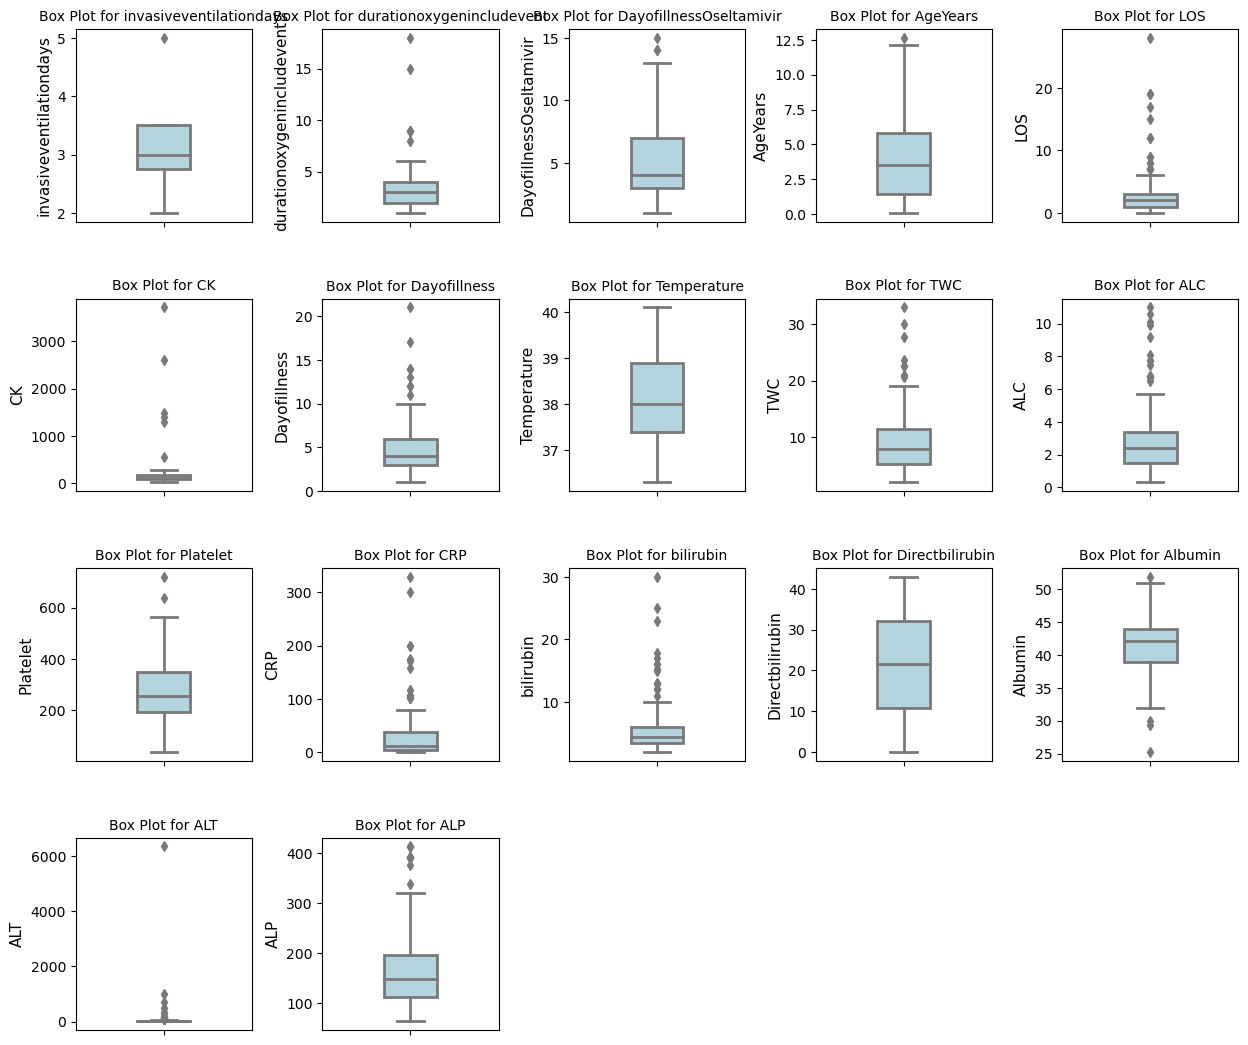

In [5]:
# check for outliers
# Create individual horizontal box plots for each continuous variable
selected_columns_contVar = df.iloc[:, 78:95]

plt.figure(figsize=(15, 20))
for i, column in enumerate(selected_columns_contVar, 1):
    plt.subplot(6, 5, i)
    sns.boxplot(y=df[column], width=0.3, color='lightblue', linewidth=2)
    plt.title(f'Box Plot for {column}', fontsize=10)
    plt.ylabel(column, fontsize=11)

# Adjust layout to prevent overlapping
plt.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust the horizontal and vertical spacing
plt.show()

In [6]:
# Outlier detection using the IQR method:
outlier_threshold = 1.5
# Pre-calculate quantiles for the continuous variables
Q1 = selected_columns_contVar.quantile(0.25)
Q3 = selected_columns_contVar.quantile(0.75)
IQR_values = Q3 - Q1
lower_limits = Q1 - outlier_threshold * IQR_values
upper_limits = Q3 + outlier_threshold * IQR_values

# Compute outlier flags: values below lower_limits or above upper_limits
outlier_flags = (selected_columns_contVar < lower_limits) | (selected_columns_contVar > upper_limits)
outliers_percentage = outlier_flags.mean() * 100  # Mean gives the fraction of outliers per column

print("Outlier Percentage for Each Continuous Variable:")
print(outliers_percentage)


Outlier Percentage for Each Continuous Variable:
invasiveventilationdays      0.564972
durationoxygenincludevent    3.389831
DayofillnessOseltamivir      1.694915
AgeYears                     0.564972
LOS                          8.474576
CK                           3.389831
Dayofillness                 4.519774
Temperature                  0.000000
TWC                          4.519774
ALC                          7.344633
Platelet                     1.129944
CRP                          6.779661
bilirubin                    7.909605
Directbilirubin              0.000000
Albumin                      2.259887
ALT                          9.604520
ALP                          4.519774
dtype: float64


NOTE: all outliers were treated as natural outliers

In [7]:
# check for missing vales 
# Replace empty strings with NaN in the selected continuous columns
df.iloc[:, 78:96] = df.iloc[:, 78:95].replace(r'^\s*$', np.nan, regex=True)

# Check for missing values in these continuous columns
missing_values = df.iloc[:, 78:95].isnull().sum()
percentage_missing = (missing_values / len(df)) * 100

print("\nPercentage Missing for Selected Continuous Columns (Columns 78 to 95):\n", percentage_missing)


Percentage Missing for Selected Continuous Columns (Columns 78 to 95):
 invasiveventilationdays      97.740113
durationoxygenincludevent    64.406780
DayofillnessOseltamivir       0.000000
AgeYears                      0.000000
LOS                           0.000000
CK                           75.141243
Dayofillness                  0.000000
Temperature                   0.000000
TWC                           0.564972
ALC                           2.824859
Platelet                      1.129944
CRP                          52.542373
bilirubin                    28.248588
Directbilirubin              98.870056
Albumin                      27.683616
ALT                          24.858757
ALP                          24.858757
dtype: float64


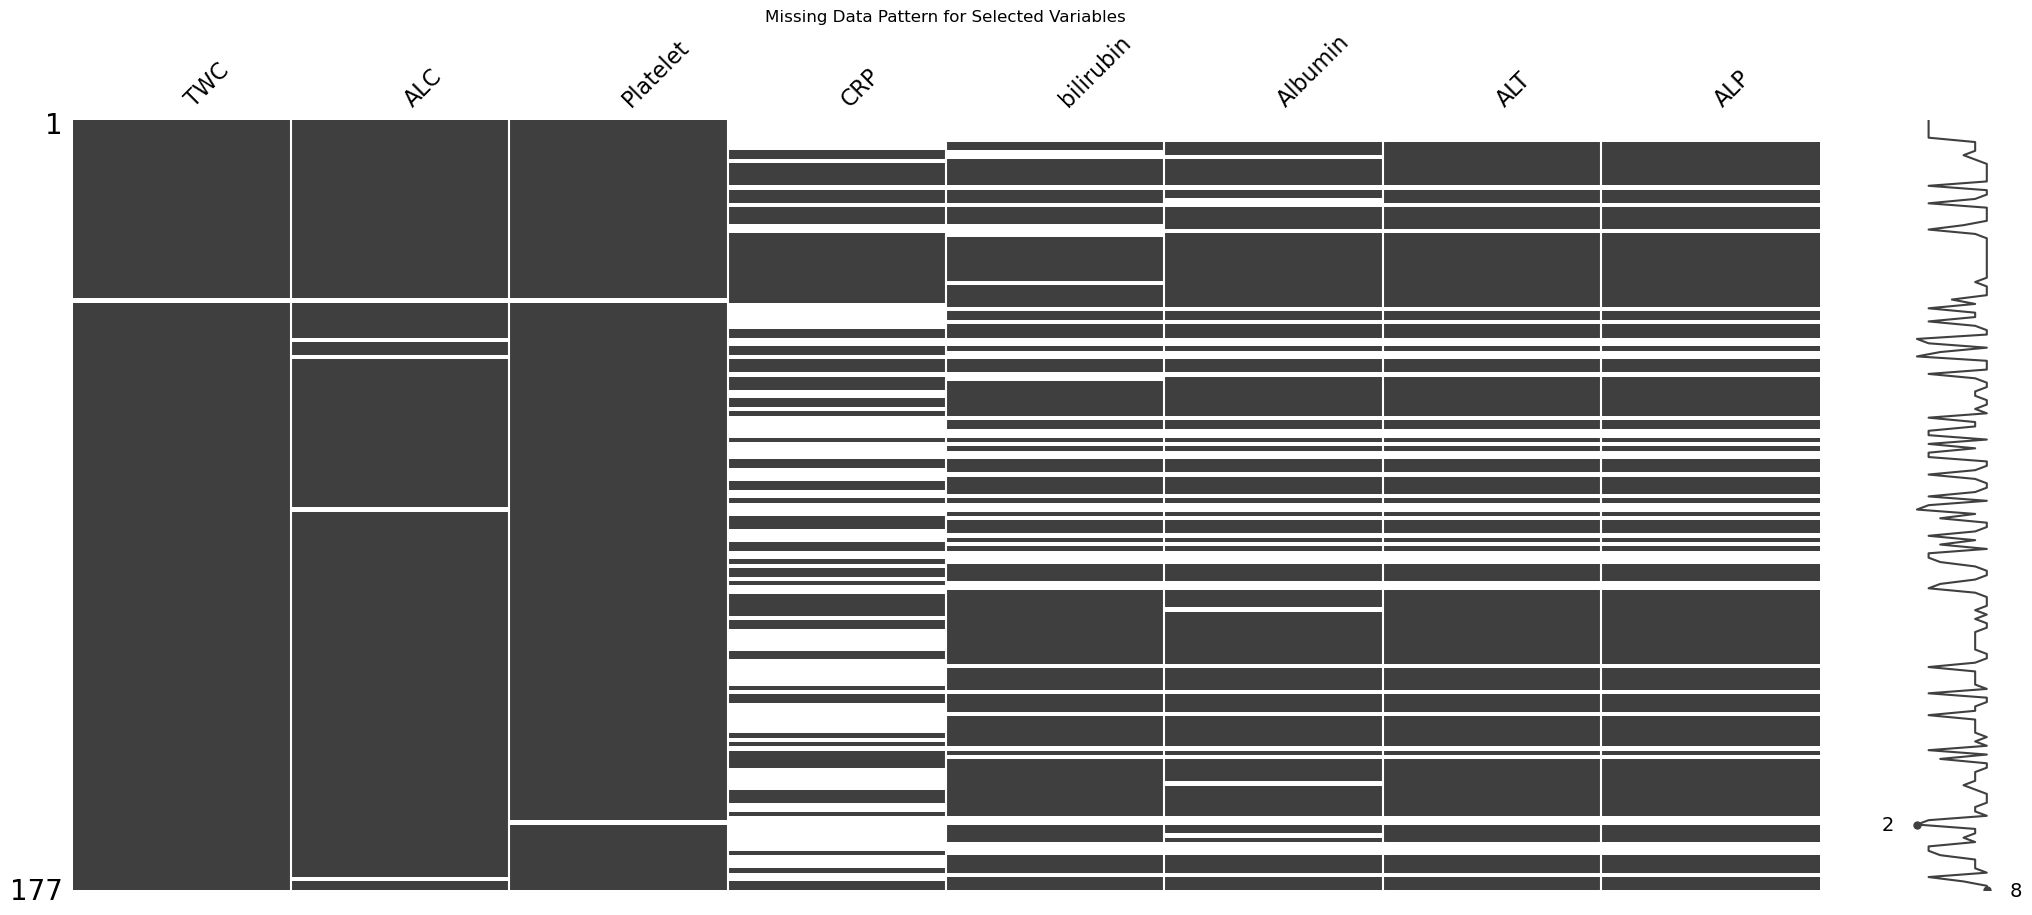

In [8]:
# Define the variables of interest
selected_vars = ['TWC', 'ALC', 'Platelet', 'CRP', 'bilirubin', 'Albumin', 'ALT', 'ALP']

# Subset the DataFrame to only include these variables
df_subset = df[selected_vars]

# --- Monkey-patch Axes.grid to fix the keyword error in missingno ---
old_grid = maxes.Axes.grid
def new_grid(self, *args, **kwargs):
    # Replace 'b' with 'visible' if present
    if 'b' in kwargs:
        kwargs['visible'] = kwargs.pop('b')
    return old_grid(self, *args, **kwargs)
maxes.Axes.grid = new_grid
# --- End of monkey-patch ---

# Visualize the missingness pattern for the selected variables
msno.matrix(df_subset)
plt.title("Missing Data Pattern for Selected Variables")
plt.show()

# Revert the monkey-patch so it doesn't affect other plots
maxes.Axes.grid = old_grid

NOTE: Missing Data Pattern
Each row represents an individual patient (N = 177), and each column represents a variable. 
Dark cells indicate observed values, while white cells denote missing data. 
The pattern shows arbitrary missingness across the dataset. 
These variables show alternating dark and white bands, indicating that missingness is distributed non-monotonically (does not follow a specific pattern)

The side panel (bar plot)= number of variables missing per patient
majority of patients have no missing data or are missing only 1–2 variables, a small number of individuals have up to 6 or more missing variables

This pattern, in combination with the results of Little’s MCAR test (p = 0.11), supports the assumption that data are Missing at Random (MAR)

In [9]:
columns_to_remove_missingness = ['Directbilirubin', 'CK']
df_delete = df.drop(columns=columns_to_remove_missingness)


NOTE:  
a. 'Directbilirubin', 'CK'have missing values > 60%, hence were dropped from analysis

b. Pairwise deletion for variables invasiveventilationdays & durationoxygenincludevent, hence was not imputed 

In [10]:
df_forMICE = df_delete.iloc[:, 3:93].copy()

# do not impute 
columns_to_drop = ['invasiveventilationdays', 'durationoxygenincludevent']  
df_forMICE.drop(columns=columns_to_drop, inplace=True)


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import HistGradientBoostingRegressor

# =========================
# === SETUP PARAMETERS ===
# =========================

selected_vars = ['TWC', 'ALC', 'Platelet', 'CRP', 'bilirubin', 'Albumin', 'ALT', 'ALP']
grouping_var = 'FluA'
additional_vars = [
    'AgeYears', 'Anycomorbidities', 'Viralfever', 'URTI', 'LRTI',
    'FebrileSeizure', 'AGE', 'AEBA', 'Temperature', 'Dayofillness'
]
impute_vars = selected_vars + additional_vars

# ============================
# === DATA PREPARATION STEP ==
# ============================

df_forMICE[selected_vars] = df_forMICE[selected_vars].apply(pd.to_numeric, errors='coerce')
df_forMICE = df_forMICE.reset_index(drop=True)

# To store imputed subsets
imputed_records = []

# ===========================
# === GROUP-WISE IMPUTATION =
# ===========================

for flu_status in df_forMICE[grouping_var].dropna().unique():
    subset = df_forMICE[df_forMICE[grouping_var] == flu_status].copy()
    original_index = subset.index

    # Drop rows where all selected_vars are missing
    fully_missing_mask = subset[selected_vars].isnull().all(axis=1)
    impute_data = subset[~fully_missing_mask][impute_vars].copy()
    dropped_data = subset[fully_missing_mask].copy()

    # MICE Setup
    imputer = IterativeImputer(
        estimator=HistGradientBoostingRegressor(random_state=42),
        max_iter=100,
        tol=1e-4,
        initial_strategy='median',
        imputation_order='ascending',
        sample_posterior=False,
        skip_complete=True,
        random_state=42
    )

    # Fit and impute
    imputed_array = imputer.fit_transform(impute_data)
    imputed_df = pd.DataFrame(imputed_array, columns=impute_vars)
    imputed_df[selected_vars] = imputed_df[selected_vars].clip(lower=0)  # Avoid negative labs

    # Recombine with fully missing rows
    for var in selected_vars:
        dropped_data[var] = dropped_data[var].fillna(imputed_df[var].median())
    combined = pd.concat([imputed_df[selected_vars], dropped_data[selected_vars]], axis=0)
    combined.index = original_index

    imputed_records.append(combined)

# Merge all imputed subsets into full dataframe
df_processed = df_forMICE.copy()
df_processed[selected_vars] = pd.concat(imputed_records).sort_index()

# ─── Add back the two non-imputed variables ────────────────
cols_to_add = ['invasiveventilationdays', 'durationoxygenincludevent']
# Align by position (since df_forMICE was reset_index, we reset df_delete as well)
df_processed[cols_to_add] = df_delete[cols_to_add].reset_index(drop=True)

C:\ProgramData\Anaconda3\envs\NewEnv\lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


NOTE: Multiple imputations
missing variables for imputation: 'TWC', 'ALC', 'Platelet', 'CRP', 'bilirubin', 'Albumin', 'ALT', 'ALP'

Impute separately for Flu-A positive vs. negative patients

features that are used as predictors in the imputation ('AgeYears', 'Anycomorbidities', 'Viralfever', 'URTI', 'LRTI',
    'FebrileSeizure', 'AGE', 'AEBA', 'Temperature', 'Dayofillness')

multiple imputation by chained equations approach (MICE) 
the imputer run up to 100 iterations
with a gradient-boosting tree model to predict the missing values. 
Rows that were entirely blank get a simple median-fill

In [12]:
# Merge all imputed subsets into full dataframe
df_processed = df_forMICE.copy()
df_processed[selected_vars] = pd.concat(imputed_records).sort_index()

# ─── Add back the two non-imputed variables ────────────────
cols_to_add = ['ID','invasiveventilationdays', 'durationoxygenincludevent']
# Align by position (since df_forMICE was reset_index, we reset df_delete as well)
df_processed[cols_to_add] = df_delete[cols_to_add].reset_index(drop=True)

print("\nFinal missing values in df_processed:")
print(df_processed[selected_vars].isnull().sum())


Final missing values in df_processed:
TWC          0
ALC          0
Platelet     0
CRP          0
bilirubin    0
Albumin      0
ALT          0
ALP          0
dtype: int64


In [13]:
# stats summary for continous variables (Post-cleaning)
selected_columns_contVar_postclean = df_processed.iloc[:, 75:88]

# Calculate percentiles, lower, upper bounds, 0.01th, and 99.98th percentiles
percentiles_processed = selected_columns_contVar_postclean.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.998]).transpose()

# Calculate lower and upper bounds
IQR = percentiles_processed['75%'] - percentiles_processed['25%']
lower_bound = percentiles_processed['25%'] - 1.5 * IQR
upper_bound = percentiles_processed['75%'] + 1.5 * IQR

# Add lower and upper bounds to the percentiles DataFrame
percentiles_processed['lower_bound'] = lower_bound
percentiles_processed['upper_bound'] = upper_bound

# Display the result
print("Stats Summary with Percentiles, Lower, Upper Bounds, 0.01th, and 99.8th Percentiles:")
print(percentiles_processed)

Stats Summary with Percentiles, Lower, Upper Bounds, 0.01th, and 99.8th Percentiles:
                         count        mean         std        min         1%  \
DayofillnessOseltamivir  177.0    4.966102    2.725924   1.000000   1.000000   
AgeYears                 177.0    3.986812    2.992129   0.093151   0.103562   
LOS                      177.0    3.220339    3.537467   0.000000   0.000000   
Dayofillness             177.0    4.768362    3.072516   1.000000   1.000000   
Temperature              177.0   38.197740    0.959756  36.300000  36.300000   
TWC                      177.0    9.004563    5.270491   1.900000   2.508000   
ALC                      177.0    2.898719    2.010603   0.300000   0.476000   
Platelet                 177.0  272.020798  112.912255  39.000000  48.000000   
CRP                      177.0   38.178800   45.839072   0.000000   0.000000   
bilirubin                177.0    5.912622    4.106055   0.953942   1.528850   
Albumin                  177.0   41

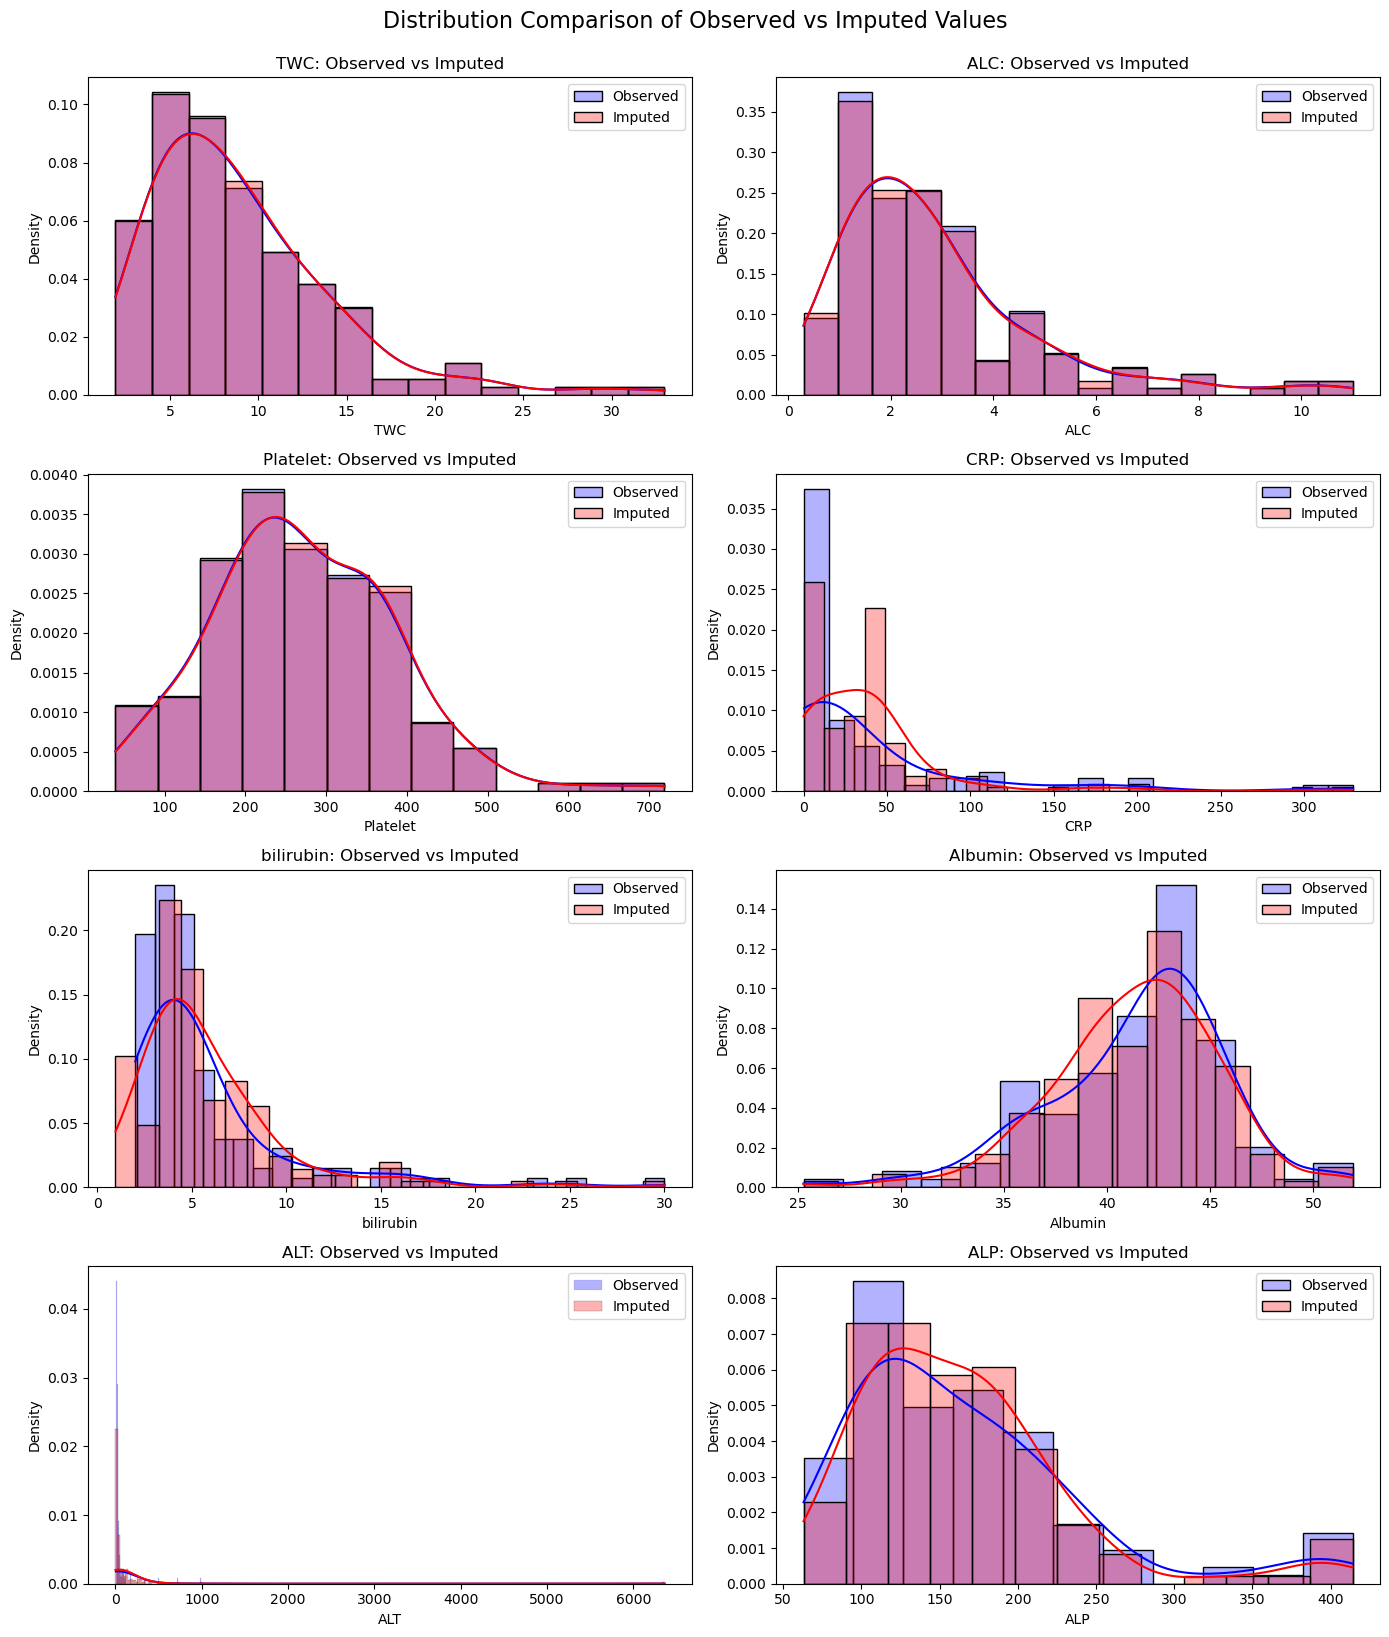

In [14]:
# Create the subplot layout: 4 rows × 2 columns
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 16))
axes = axes.flatten()  # Flatten to easily index from 0 to 7

# Create missingness mask for reference (optional)
missing_mask = df_forMICE[selected_vars].isnull().reset_index(drop=True)

# Loop through selected variables and plot on subplots
for i, var in enumerate(selected_vars):
    ax = axes[i]
    
    observed = df_forMICE[var].dropna()
    imputed = df_processed[var].dropna()

    sns.histplot(observed, color='blue', label='Observed', kde=True, stat="density", alpha=0.3, ax=ax)
    sns.histplot(imputed, color='red', label='Imputed', kde=True, stat="density", alpha=0.3, ax=ax)

    ax.set_title(f"{var}: Observed vs Imputed", fontsize=12)
    ax.set_xlabel(var)
    ax.legend()

# Remove any unused subplot axes if selected_vars < total subplots
for j in range(len(selected_vars), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Distribution Comparison of Observed vs Imputed Values", fontsize=16, y=1.02)
plt.show()


NOTE: Data distribution of imputed values closely resembles original values, except for CRP

In [15]:
# Normality Assesment
# Check normality using Kolmogorov–Smirnov test and QQ plot

cont_variables_df = df_processed.columns[75:93]

for column in cont_variables_df:
    # Exclude missing values before conducting tests
    data = df_processed[column].dropna()

    # Kolmogorov–Smirnov test
    kstest_result = stats.kstest(data, 'norm')
    p_value_formatted = "{:.3f}".format(kstest_result.pvalue)
    print(f'Kolmogorov–Smirnov test for {column}: p-value = {p_value_formatted}')



Kolmogorov–Smirnov test for DayofillnessOseltamivir: p-value = 0.000
Kolmogorov–Smirnov test for AgeYears: p-value = 0.000
Kolmogorov–Smirnov test for LOS: p-value = 0.000
Kolmogorov–Smirnov test for Dayofillness: p-value = 0.000
Kolmogorov–Smirnov test for Temperature: p-value = 0.000
Kolmogorov–Smirnov test for TWC: p-value = 0.000
Kolmogorov–Smirnov test for ALC: p-value = 0.000
Kolmogorov–Smirnov test for Platelet: p-value = 0.000
Kolmogorov–Smirnov test for CRP: p-value = 0.000
Kolmogorov–Smirnov test for bilirubin: p-value = 0.000
Kolmogorov–Smirnov test for Albumin: p-value = 0.000
Kolmogorov–Smirnov test for ALT: p-value = 0.000
Kolmogorov–Smirnov test for ALP: p-value = 0.000
Kolmogorov–Smirnov test for invasiveventilationdays: p-value = 0.000
Kolmogorov–Smirnov test for durationoxygenincludevent: p-value = 0.000


NOTE: All continuous data have Kolmogorov–Smirnov test p-vaue < 0.001
indicating skewed distribution

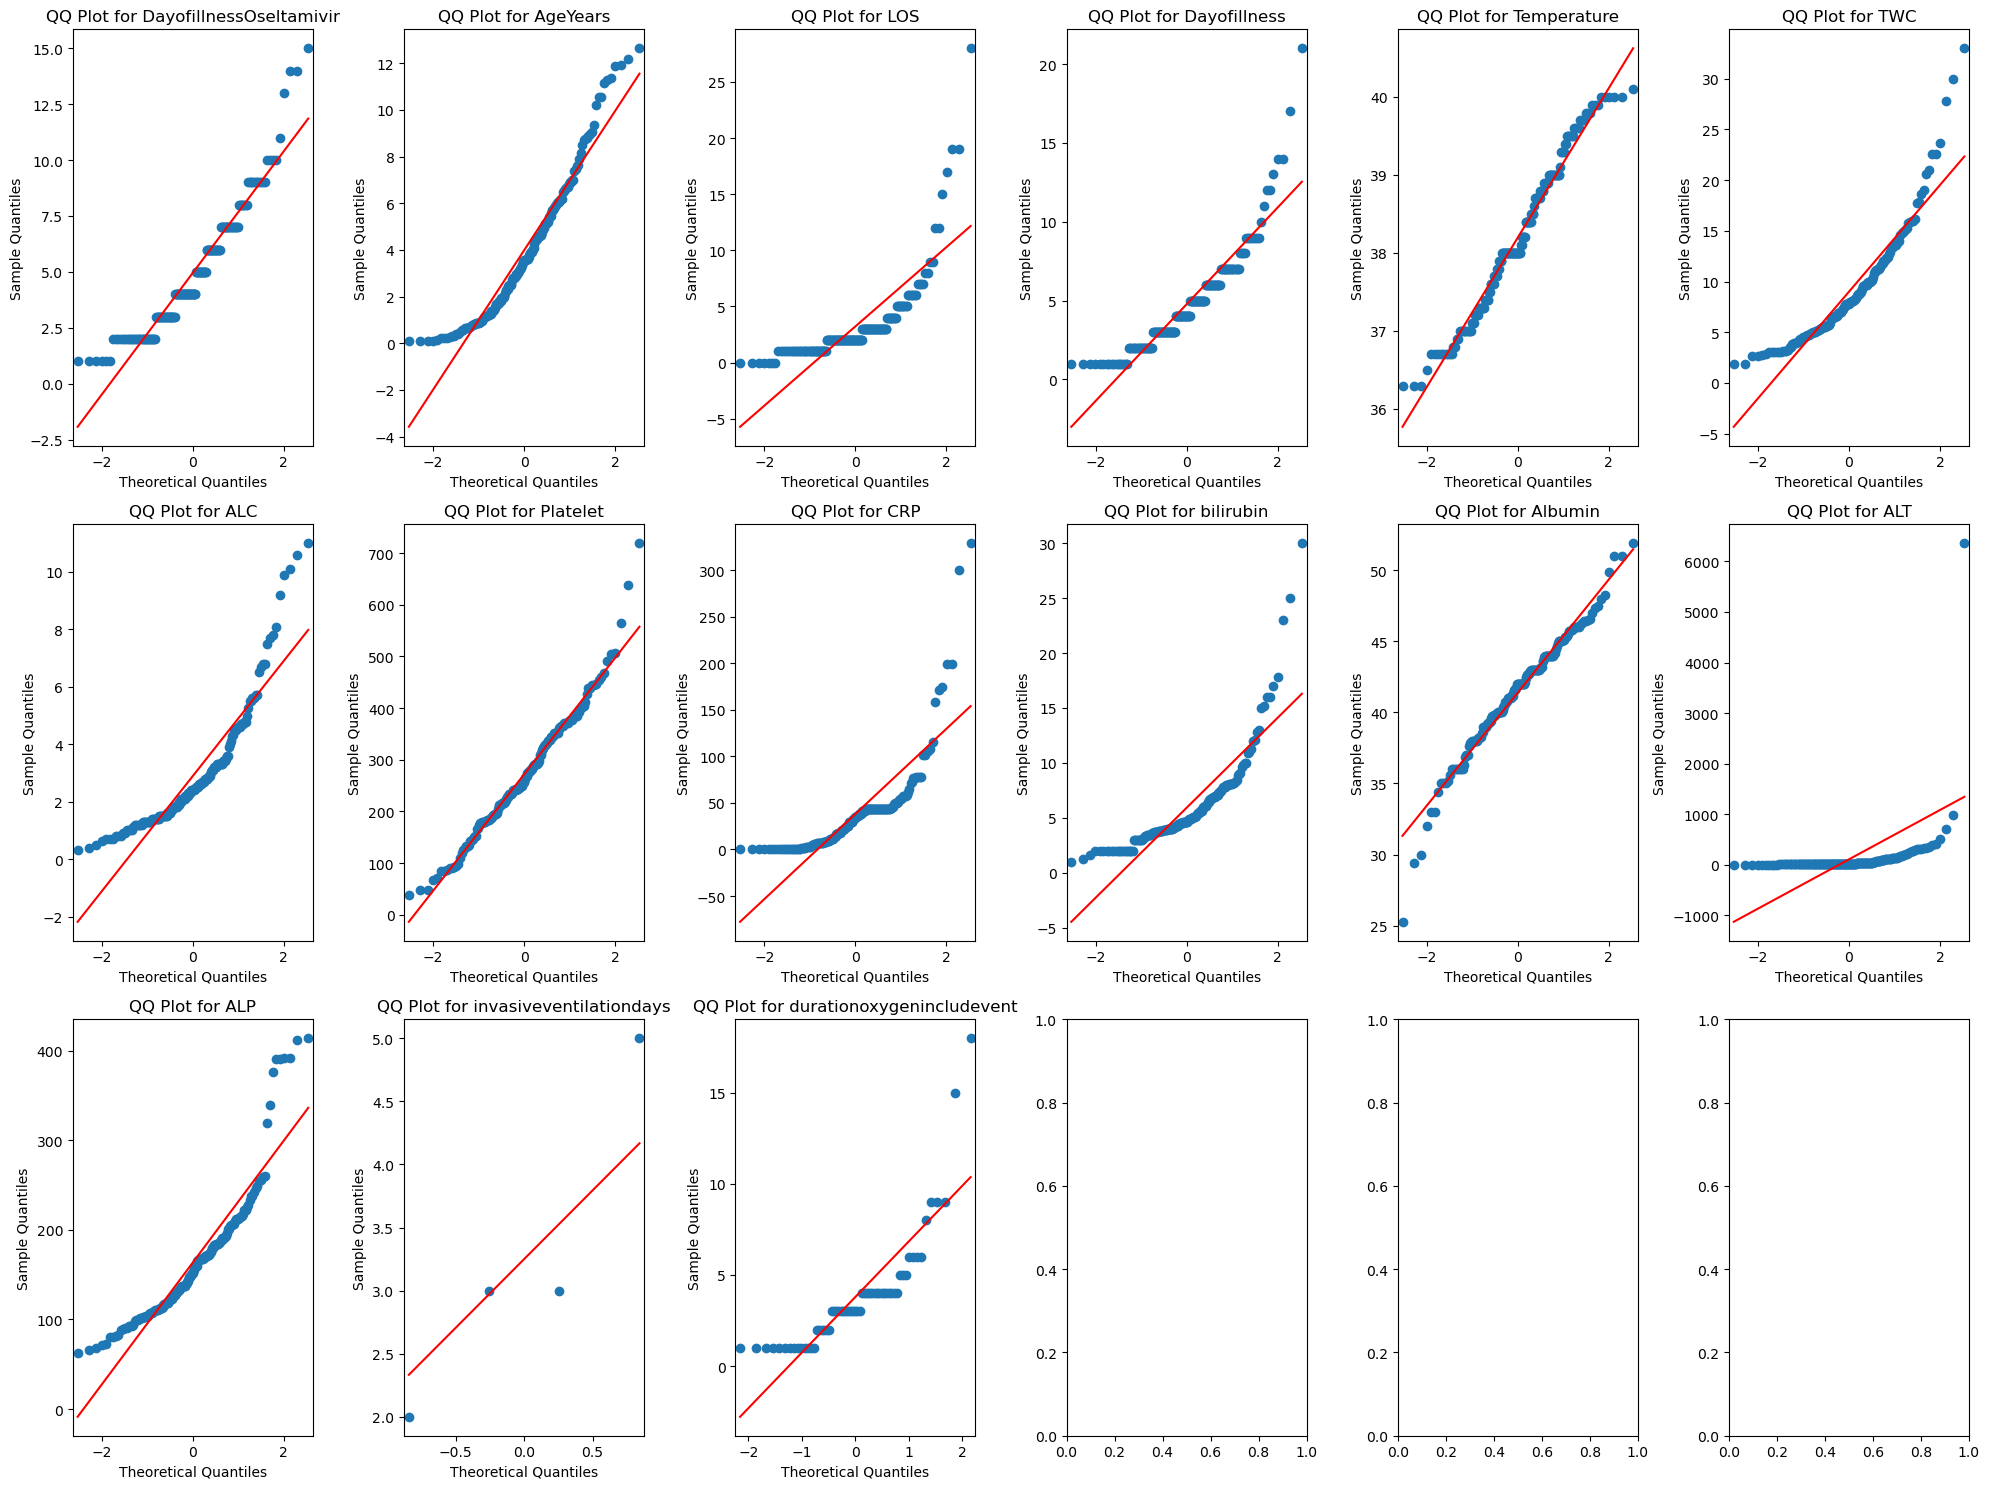

In [16]:
# Combine QQ plots into subplots
num_plots = len(cont_variables_df)
num_cols = 6
num_rows = (num_plots + num_cols - 1) // num_cols  # Adjust to include the last row

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 15))

for i, column in enumerate(cont_variables_df):
    row = i // num_cols
    col = i % num_cols

    # QQ plot
    sm.qqplot(df_processed[column].dropna(), line='s', ax=axes[row, col])
    axes[row, col].set_title(f'QQ Plot for {column}')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

NOTE: All continuous data non-linear QQ plots
indicating skewed distribution

In [ ]:
# Save dataset
df_processed = df_processed.iloc[:, 0:93].copy()
# csv_file_path = r'E:/1 PROJECT/RESEARCH PROJECTS/HTJ res/influenza/Data/flu/data_flu_processedMay2025.csv'
# df_processed.to_csv(csv_file_path, index=False)

# excel_file_path = r'E:/1 PROJECT/RESEARCH PROJECTS/HTJ res/influenza/Data/FluCovid_processedData.xlsx'
# df_processed.to_excel(excel_file_path, index=False)